A.S. Lundervold, 27.10.22

# Introduction

This notebook shows how the molecular fingerprints and images used in `1.1-representations-representing_data_as_images.ipynb` were generated. 

To run the notebook you must install `rdkit`: https://www.rdkit.org/docs/Install.html. See the README.md file for details. 

The data from the source article 
> [1] https://jcheminf.biomedcentral.com/articles/10.1186/s13321-017-0226-y 

is downloaded in the notebook from the direct link 

> https://static-content.springer.com/esm/art%3A10.1186%2Fs13321-017-0226-y/MediaObjects/13321_2017_226_MOESM2_ESM.zip

> Note that this notebook isn't currently designed to be runnable in Colab. However, you can install the necessary libraries and downloading the necessary data on your own computer. See the README.md file for Part 2 of the deep learning module for details. It is also possible to modify the notebooks to make them runnable on Colab (or a similar cloud solution) by repeating our approach from the Part 1 notebooks.

# Setup

In [1]:
%matplotlib inline
import pandas as pd, numpy as np
from pathlib import Path
import shutil
import urllib

In [2]:
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [4]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'data'/'drug'
DATA.mkdir(exist_ok=True, parents=True)

RAWDATA = DATA/'raw'
RAWDATA.mkdir(exist_ok=True, parents=True)

INTERIMDATA = DATA/'interim'
INTERIMDATA.mkdir(exist_ok=True, parents=True)

# Location to store image files (change this as you see fit)
IMGDATA = Path('/data-ssd/molimages/')
IMGDATA.mkdir(exist_ok=True, parents=True)

# Get the data

In [5]:
list(DATA.iterdir())

[PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/interim'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw')]

In [6]:
dataurl = 'https://static-content.springer.com/esm/art%3A10.1186%2Fs13321-017-0226-y/MediaObjects/13321_2017_226_MOESM1_ESM.zip'

In [7]:
fn, _ = urllib.request.urlretrieve(dataurl, DATA/'raw'/'13321_2017_226_MOESM1_ESM.zip')

In [8]:
shutil.unpack_archive(fn, extract_dir=DATA/'raw')

In [9]:
list(RAWDATA.iterdir())

[PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL1978_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL301_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/RdkitDescriptors.py'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL218_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL240_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL219_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL205_cl.csv'),
 PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nb

In [10]:
datasets = sorted([d.stem for d in RAWDATA.glob('*.csv')])

In [11]:
datasets

['CHEMBL1978_cl',
 'CHEMBL205_cl',
 'CHEMBL218_cl',
 'CHEMBL219_cl',
 'CHEMBL240_cl',
 'CHEMBL244_cl',
 'CHEMBL301_cl']

In [12]:
pd.read_csv(str(RAWDATA/datasets[0])+'.csv').head()

,CID,SMILES,Activity
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1


# Get fingerprints

We compute the fingerprints in the same manner as in [1].

In [13]:
def get_fp(smile,diam=2,bits=1024,verbose=0):
    """
    Returns the fingerprint of the given smile, for the given diam and 
    number of bits.
    Returns an rdkit data structure (analogous to a list of booleans of length # bits)
    """
    mol = Chem.MolFromSmiles(smile)
    Chem.SanitizeMol(mol)
    fp=AllChem.GetMorganFingerprintAsBitVect(mol,diam,nBits=bits)
    
    if verbose:
        print(f"SMILE: {smile}")
        display(mol)
        
    return list(fp)

SMILE: CNC(=O)[C@@H](NC(=O)N1C(=O)N(CCN2CCOCC2)c3ccccc13)C(C)(C)C


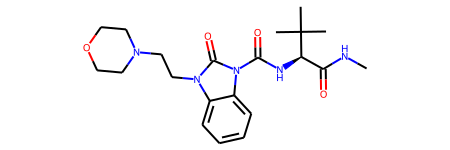

In [14]:
fp = get_fp(
            smile='CNC(=O)[C@@H](NC(=O)N1C(=O)N(CCN2CCOCC2)c3ccccc13)C(C)(C)C', 
            diam=2, 
            bits=1024, 
            verbose=1
            )

In [15]:
def ECFP(ifile,ofile,diam,bits):
    """
    Generates circular fingerprints ECFP4 hashed into n bits length vectors
    Updated version of RdkitDescriptors.py. Works with Py3 (ASL)
    """
    
    print(f"Reading data from file {ifile}")
    df = pd.read_csv(ifile)    
    
    # Insert the ECFP fingerprints in a new column
    #df.insert(2, "ECFP4_", df.SMILES.apply(get_fp))
    df.insert(2, "ECFP4_", df.SMILES.apply(get_fp))
    # Split the column. Follow naming convention of RdkitDescriptors.py
    df[[f"ECFP4_{i+1}" for i in range(len(df.ECFP4_[0]))]] = df.ECFP4_.to_list()
    # Drop the now superfluous column
    df.drop("ECFP4_", axis=1, inplace=True)
    ###########################################
    
    df = df.copy()
    
    # Save the outputs
    df.to_csv(ofile, index=None)
    print(f"Outputs saved to {ofile}")
    
    return df    

# Run on some data sets and store the results

In [16]:
INTERIMDATA

PosixPath('/home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/interim')

In [17]:
def get_fp_df(dataset, diam=2, bits=1024):
    infn = f'{RAWDATA/dataset}.csv'
    outfn = f'{INTERIMDATA/dataset}_ecfp_{bits}.csv'
    df = ECFP(infn, outfn, diam, bits)
    return df

**Test**

In [18]:
datasets[0]

'CHEMBL1978_cl'

In [19]:
df = get_fp_df(datasets[0])

Reading data from file /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL1978_cl.csv
Outputs saved to /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/interim/CHEMBL1978_cl_ecfp_1024.csv


In [20]:
df.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


**Run on all the datasets**

In [22]:
for dataset in datasets:
    df = get_fp_df(dataset)

Reading data from file /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL1978_cl.csv
Outputs saved to /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/interim/CHEMBL1978_cl_ecfp_1024.csv
Reading data from file /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL205_cl.csv
Outputs saved to /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/interim/CHEMBL205_cl_ecfp_1024.csv
Reading data from file /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL218_cl.csv
Outputs saved to /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/interim/CHEMBL218_cl_ecfp_1024.csv
Reading data from file /home/ubuntu/Dropbox/medGPU-alex/PCS956-DL-2022/Part-2-practical_deep_learning/nbs/data/drug/raw/CHEMBL219_cl.csv
Outputs saved t

# Generate PNGs of molecular graphs

In [24]:
df = pd.read_csv(INTERIMDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [25]:
test_smile = df.loc[df.CID == 'CHEMBL1454842'].SMILES.values[0]
test_smile

's1nc(nc1-c1ccncc1)-c1ccncc1'

In [26]:
mol = Chem.MolFromSmiles(test_smile)

In [27]:
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

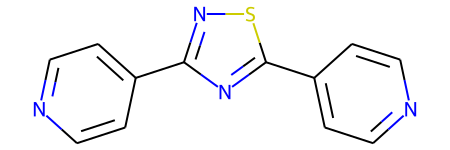

In [28]:
mol

# Create image representations for the seven bioactivity classes

1. CHEMBL205: Carbonic Anhydrase II, a protein lyase
2. CHEMBL301: Cyclin-dependent kinase 2, a protein kinase
3. CHEMNL240: ether-a-go-go-related gene potassium channel 1 (HERG)
4. CHEMBL219: Dopamine D4 receptor, a monoamine GPCR
5. CHEMBL244: Coagulation factor X, a serine protease
6. CHEMBL218: Cannabinoid CB1 receptor, a lipid-like GPCR
7. CHEMBL1978: Cytochrome P450 19A1, a cytochrome P450

In [29]:
def create_images(dataset, output_folder, size=(500,500), verbose=1):
    """
    Generate molecular drawings from the fingerprints in the input data 
    set using `rdkit`. Store the resulting images in `output_folder`.
    """
    output_folder = output_folder/dataset
    output_folder.mkdir(exist_ok=True)
    df = pd.read_csv(INTERIMDATA/f'{dataset}_ecfp_1024.csv')
    
    if verbose: 
        print(f"Processing {dataset}. {len(df)} images...")
        print(f"Outputs stored in {output_folder}")
        

    for idx, row in df.iterrows(): 
        cid = row.CID
        smile = row.SMILES
        mol = Chem.MolFromSmiles(smile)
        Chem.SanitizeMol(mol)
        Chem.Draw.MolToFile(mol, output_folder/f'{cid}.png', size=(300, 300), imageType="png")

In [30]:
for dataset in datasets:
    create_images(dataset, output_folder=IMGDATA, verbose=1)

Processing CHEMBL1978_cl. 6831 images...
Outputs stored in /data-ssd/molimages/CHEMBL1978_cl
Processing CHEMBL205_cl. 17941 images...
Outputs stored in /data-ssd/molimages/CHEMBL205_cl
Processing CHEMBL218_cl. 20924 images...
Outputs stored in /data-ssd/molimages/CHEMBL218_cl
Processing CHEMBL219_cl. 5566 images...
Outputs stored in /data-ssd/molimages/CHEMBL219_cl
Processing CHEMBL240_cl. 7700 images...
Outputs stored in /data-ssd/molimages/CHEMBL240_cl
Processing CHEMBL244_cl. 12584 images...
Outputs stored in /data-ssd/molimages/CHEMBL244_cl
Processing CHEMBL301_cl. 7755 images...
Outputs stored in /data-ssd/molimages/CHEMBL301_cl
